### 나주 데이터

In [637]:
import pandas as pd
import glob
from datetime import datetime
import numpy as np

# 한국의 공휴일, version : 1.1.1
from workalendar.asia import SouthKorea 

holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2018))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2017))[:, 0])]).reset_index(drop=True)

In [638]:
# 2017년 ~ 2018년 data 취합

path_list = [r'data/경진대회_나주시_전력사용량 DATA1', r'data/경진대회_나주시_전력사용량 DATA2', r'data/경진대회_나주시_전력사용량 DATA3']

li = []
for path in path_list:
    all_files = glob.glob(path + "/*.csv")
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, encoding='euc-kr')
        li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

/usr/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [639]:
frame.tail()

,날짜,시간,시/도,시/군/구,읍/면/동,고객(가칭),계약종별,계약전력,유효전력,지상무효전력,진상무효전력
67769093,20180930,1704,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,NaN,NaN,NaN
67769094,20180930,1715,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,0.0,0,0
67769095,20180930,1800,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,0.0,0,0
67769096,20180930,1808,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,NaN,NaN,NaN
67769097,20180930,2200,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,0.0,0,0


In [640]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67769098 entries, 0 to 67769097
Data columns (total 11 columns):
날짜        int64
시간        int64
시/도       object
시/군/구     object
읍/면/동     object
고객(가칭)    object
계약종별      object
계약전력      int64
유효전력      float64
지상무효전력    object
진상무효전력    object
dtypes: float64(1), int64(3), object(7)
memory usage: 5.6+ GB


In [641]:
frame['날짜'] = pd.to_datetime(frame['날짜'], format="%Y%m%d")
frame['시간'] = frame['시간'].astype(str)

In [642]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67769098 entries, 0 to 67769097
Data columns (total 11 columns):
날짜        datetime64[ns]
시간        object
시/도       object
시/군/구     object
읍/면/동     object
고객(가칭)    object
계약종별      object
계약전력      int64
유효전력      float64
지상무효전력    object
진상무효전력    object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 5.6+ GB


## 전처리
---

### 1. datetime으로 변환

#### **Issue** 

- 날짜 : `20170228`
- 시간 : `2400`

> `20170301`+ `0000` 으로 변경하고 이를 `format = datetime64[ns]`으로 `datetime`이라는 새로운 column 생성 

In [643]:
frame.loc[frame['시간'] == '2400', '날짜'] = frame['날짜'] + pd.DateOffset(days=1)
frame['시간'] = frame['시간'].apply(lambda x : '0000' if '2400' in str(x) else str(x).zfill(4))
frame['datetime'] = pd.to_datetime(frame['날짜'].astype(str) + ' ' + frame['시간'].apply(lambda x: x[0:2]) + ':' + frame['시간'].apply(lambda x: x[2:]))

In [644]:
frame.tail()

,날짜,시간,시/도,시/군/구,읍/면/동,고객(가칭),계약종별,계약전력,유효전력,지상무효전력,진상무효전력,datetime
67769093,2018-09-30,1704,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,NaN,NaN,NaN,2018-09-30 17:04:00
67769094,2018-09-30,1715,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,0.0,0,0,2018-09-30 17:15:00
67769095,2018-09-30,1800,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,0.0,0,0,2018-09-30 18:00:00
67769096,2018-09-30,1808,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,NaN,NaN,NaN,2018-09-30 18:08:00
67769097,2018-09-30,2200,전라남도,나주시,AA48동,AA1370호,산업용(갑)저압,8,0.0,0,0,2018-09-30 22:00:00


In [645]:
frame = frame.sort_values(by = 'datetime')

### 2. 고객 분류 I

#### **Issue** 

- 읍/면/동 : 비식별화
- 고객(가정) :  비식별화
- 계약종별 : 구분 필요
> `읍/면/동` + `고객(가정)` + `계약종별` 을 **하나의 user**로 봐야하기 때문에, 이를 고려한 새로운 **`user`**라는 새로운 column 생성

In [657]:
frame.groupby(['읍/면/동', '고객(가칭)', '계약종별']).count().head(10)

날짜    시간   시/도  시/군/구  계약전력  유효전력  지상무효전력  진상무효전력  \
읍/면/동  고객(가칭)  계약종별                                                         
AA100동 AA1517호 주택용전력   181   181   181    181   181   174     174     174   
       AA1540호 주택용전력  2188  2188  2188   2188  2188  2065    2065    2065   
       AA1664호 주택용전력  2472  2472  2472   2472  2472  2275    2275    2275   
       AA1685호 주택용전력  2497  2497  2497   2497  2497  2419    2419    2419   
       AA1695호 주택용전력  2817  2817  2817   2817  2817  2750    2750    2750   
       AA1705호 주택용전력  2700  2700  2700   2700  2700  2638    2638    2638   
       AA307호  주택용전력  2367  2367  2367   2367  2367  2214    2214    2214   
       AA314호  주택용전력  2462  2462  2462   2462  2462  2381    2381    2381   
       AA321호  주택용전력  2706  2706  2706   2706  2706  2644    2644    2644   
       AA323호  주택용전력  2858  2858  2858   2858  2858  2795    2795    2795   

                      datetime  
읍/면/동  고객(가칭)  계약종별             
AA100동 AA1517호 주택용전력       181  
       AA1540호 주택용전력      2188  
       AA1664호 주택용전력      2472  
       AA1685호 주택용전력      2497  
       AA1695호 주택용전력      2817  
       AA1705호 주택용전력      2700  
       AA307호  주택용전력      2367  
       AA314호  주택용전력      2462  
       AA321호  주택용전력      2706  
       AA323호  주택용전력      2858

In [469]:
frame.loc[frame['계약종별'] == '주택용전력', 'contract_type'] = 0
frame.loc[frame['계약종별'] == '일반용(갑)저압', 'contract_type'] = 1
frame.loc[frame['계약종별'] == '산업용(갑)저압', 'contract_type'] = 2
frame.loc[frame['계약종별'] == '심야전력(갑)', 'contract_type'] = 3
frame.loc[frame['계약종별'] == '농사용(을)저압', 'contract_type'] = 4
frame.loc[frame['계약종별'] == '농사용(갑)', 'contract_type'] = 5
frame.loc[frame['계약종별'] == '교육용(갑)저압', 'contract_type'] = 6
frame.loc[frame['계약종별'] == '가로등(을)', 'contract_type'] = 7

In [471]:
frame['contract_type'] =  frame['contract_type'].astype(int)

In [446]:
frame[frame['고객(가칭)'] == 'AA1370호']['읍/면/동'].value_counts()

AA104동    2947
AA102동    2895
AA111동    2851
AA58동     2768
AA120동    2471
AA126동    2253
AA48동     1805
Name: 읍/면/동, dtype: int64

In [447]:
frame[frame['고객(가칭)'] == 'AA1370호']['계약종별'].value_counts()

주택용전력       5366
일반용(갑)저압    5200
심야전력(갑)     2851
농사용(을)저압    2768
산업용(갑)저압    1805
Name: 계약종별, dtype: int64

In [474]:
frame['user'] = frame['읍/면/동'] + '_' + frame['고객(가칭)'] + '_' + frame['contract_type'].astype(str)

In [416]:
len(frame['user'].value_counts())

19828

### 3. 필요한 Column 설정

1. **영어로 통일 필요**
    - `계약종별` =  `contract_type`
    - `유효전력` =  `active_power`  
    
    
2. **필요한 컬럼 협의 필요**
    - `datetime`
    - `local` : `나주시 = 0`, `인천광역시 = 1`
    - `user`
    - `contract_type`
    - `active_power`

In [516]:
frame.loc[frame['시/군/구'] == '나주시', 'local'] = 0
frame['local'] = frame['local'].astype(int)

In [517]:
frame.rename(columns = {'유효전력' : 'active_power'}, inplace = True)
column_list = ['datetime', 'local', 'user', 'contract_type', 'active_power']

In [518]:
new_frame = frame[column_list]

In [519]:
new_frame.head()

,datetime,local,user,contract_type,active_power
0,2017-09-01 00:15:00,0,AA11동_AA279호_1,1,0.522
1,2017-09-01 00:15:00,0,AA1동_AA278호_1,1,0.014
2,2017-09-01 00:15:00,0,AA10동_AA328호_1,1,0.167
3,2017-09-01 00:30:00,0,AA11동_AA279호_1,1,0.370
4,2017-09-01 00:30:00,0,AA1동_AA278호_1,1,0.025


In [520]:
new_frame.tail()

,datetime,local,user,contract_type,active_power
67769093,2018-09-30 17:04:00,0,AA48동_AA1370호_2,2,NaN
67769094,2018-09-30 17:15:00,0,AA48동_AA1370호_2,2,0.0
67769095,2018-09-30 18:00:00,0,AA48동_AA1370호_2,2,0.0
67769096,2018-09-30 18:08:00,0,AA48동_AA1370호_2,2,NaN
67769097,2018-09-30 22:00:00,0,AA48동_AA1370호_2,2,0.0


### 4. 고객 분류 II

#### 계약종별에 따른 dataframe 분리

> **이유** : 소모하는 전력량 차이 있을것으로 판단, 비식별된 user가 계약종별로 중복되고 있음 발견!  
>
> **참고** : [한글 전기요금표](http://cyber.kepco.co.kr/ckepco/front/jsp/CY/E/E/CYEEHP00102.jsp) 에서 계약종 설명되어 있음
- **df_group_A** : 주택용전력     (0) -> 저압(3kW 이하의 고객) 및 고압으로 구분
- **df_group_B** : 일반용(갑)저압 (1) -> 계약 전력 300kW 미만 고객
- **df_group_C** : 산업용(갑)저압 (2) -> 광업, 제조업 및 기타사업에 전력을 사용하는 계약전력 4kW 이상 300kW 미만의 고객
- **df_group_D** : 심야전력(갑)   (3) -> ...
- **df_group_E** : 농사용(을)저압 (4) -> 계약전력 1,000kW 미만의 고객으로 농사용전력(갑) 이외의 고객
- **df_group_F** : 농사용(갑)     (5) -> 양곡생산을 위한 양수, 배수펌프 및 수문조작에 사용하는 전력
- **df_group_G** : 교육용(갑)저압 (6) -> 계약전력 1,000kW 미만의 고객
- **df_group_H** : 가로등(을)     (7) -> ...

In [658]:
df_group_A = new_frame[new_frame['contract_type'] == 0].sort_values(by = 'datetime')
df_group_B = new_frame[new_frame['contract_type'] == 1].sort_values(by = 'datetime')
df_group_C = new_frame[new_frame['contract_type'] == 2].sort_values(by = 'datetime')
df_group_D = new_frame[new_frame['contract_type'] == 3].sort_values(by = 'datetime')
df_group_E = new_frame[new_frame['contract_type'] == 4].sort_values(by = 'datetime')
df_group_F = new_frame[new_frame['contract_type'] == 5].sort_values(by = 'datetime')
df_group_G = new_frame[new_frame['contract_type'] == 6].sort_values(by = 'datetime')
df_group_H = new_frame[new_frame['contract_type'] == 7].sort_values(by = 'datetime')

- **점검** : `AA10동 AA293호`가 계약 유형별로 실제로 `주택용전력`, `일반용(갑)저압`, `산업용(갑)저압`, `심야전력(갑)` 에 포함되어 있음 따라서 그룹별로 나눠야지 완전한 식별을 해야한다.

In [40]:
df_group_A[['datetime', 'user', 'active_power']].groupby('user').count().loc['AA10동 AA293호']

datetime        8597
active_power    8597
Name: AA10동 AA293호, dtype: int64

In [41]:
df_group_B[['datetime', 'user', 'active_power']].groupby('user').count().loc['AA10동 AA293호']

datetime        8792
active_power    8792
Name: AA10동 AA293호, dtype: int64

In [42]:
df_group_C[['datetime', 'user', 'active_power']].groupby('user').count().loc['AA10동 AA293호']

datetime        2970
active_power    2970
Name: AA10동 AA293호, dtype: int64

In [43]:
df_group_D[['datetime', 'user', 'active_power']].groupby('user').count().loc['AA10동 AA293호']

datetime        2896
active_power    2850
Name: AA10동 AA293호, dtype: int64

## EDA 

- 결측값 확인
- 목표 : target은 12 hour 이후의 예측
- LSTM 사용하면 학습에 필요한 sequence 고려해야함 (sequence = ?)

user별로 `N/A` 값 분포 확인 필요

In [36]:
df_group_A['user'].value_counts()

AA8동 AA23호        23037
AA3동 AA51호        19864
AA11동 AA244호      14537
AA11동 AA239호      14427
AA11동 AA125호      14367
AA8동 AA75호        14346
AA8동 AA12호        14339
AA8동 AA26호        14338
AA8동 AA33호        14331
AA8동 AA5호         14328
AA13동 AA29호       14145
AA4동 AA160호       14045
AA11동 AA37호       13174
AA8동 AA837호       11694
AA12동 AA385호      11536
AA8동 AA169호       11522
AA7동 AA851호       11418
AA11동 AA86호       11406
AA11동 AA109호      11404
AA10동 AA105호      11403
AA11동 AA82호       11403
AA11동 AA108호      11403
AA3동 AA63호        11400
AA11동 AA72호       11398
AA4동 AA59호        11376
AA11동 AA39호       11362
AA5동 AA605호       11324
AA4동 AA16호        11314
AA11동 AA719호      11248
AA4동 AA159호       11188
                  ...  
AA66동 AA1625호       178
AA65동 AA1434호       169
AA12동 AA327호        167
AA68동 AA1478호       164
AA68동 AA1386호       157
AA99동 AA1408호       152
AA73동 AA1385호       149
AA98동 AA1424호       147
AA104동 AA1199호      145
AA8동 AA776호         140
AA7동 AA599호     

### 그룹별로 결측값이 가장 적은 `상위 10개 user` 시각화

In [579]:
def get_multiple_elements_in_list(in_list, in_dicies):
    return [in_list[i] for i in in_dicies]

In [602]:
df_group_A[(df_group_A['datetime'] >= '2017-8-1') & (df_group_A['datetime'] < '2018-3-1')][['user', 'datetime', 'active_power']].groupby('user').count().sort_values(by=['active_power'], ascending=False).head(10)

,datetime,active_power
user,,
AA8동_AA23호_0,20061,20061
AA11동_AA125호_0,14366,14366
AA8동_AA12호_0,14338,14338
AA8동_AA26호_0,14337,14337
AA8동_AA33호_0,14330,14330
AA8동_AA5호_0,14327,14327
AA13동_AA29호_0,14144,14144
AA11동_AA37호_0,13173,13173
AA12동_AA385호_0,11536,11536


In [651]:
import matplotlib.pylab as plt

def df_multiple_visualize(df, counts, width, height, start_time = '2017-1-1', end_time = '2018-12-31'):
    '''
    Active power visualization function consisting of data frames
    
    # input
    df : DataFrame
    counts : 시각화하고 싶은 갯수
    width : figsize width
    height : figsize height
    start_time : 시작 날짜(일 단위), e.g. "2017-1-1" 
    end_time : 종료 날짜(일 단위), e.g. "2019-1-1"    
    
    # output
    lists : 시간 조건에 부합하는 구간에 관측된 데이터 갯수 (counts)
    시각화 : 시간에 따른 id 별 유효전력 시각화
    '''
    
    fig, axs = plt.subplots(counts, figsize=(width, height), constrained_layout=True, sharex=True, sharey=True)
    # fig.suptitle('df_group_A_Top 10 Power')
    
    lists = list(df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)][['user', 'datetime', 'active_power']].groupby('user').count().sort_values(by=['active_power'], ascending=False).index[:counts])
    # df[(df['datetime'] >= starttime) & (df['datetime'] < endtime)][['user', 'datetime', 'active_power']].groupby('user').count().sort_values(by=['active_power'], ascending=False).index[:counts]
    
    for i, j in enumerate(lists):
        axs[i].plot(df[df['user'] == j]['datetime'], df[df['user'] == j]['active_power'], 'rs--')
        axs[i].set_title(j + ' counts : ' + str(len(df[(df['user'] == j) & (df['datetime'] >= start_time) & (df['datetime'] <= end_time)]['active_power'])))
        axs[i].set_ylabel(i)
    plt.xlim(start_time, end_time)
        
    return lists

### `나주시` 날씨 데이터 업로드



In [652]:
# 2017년 ~ 2018년 날씨 data 취합

path_list = [r'data/weather_data/NJ']

li = []
for path in path_list:
    all_files = glob.glob(path + "/*.csv")
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=None, encoding='euc-kr', names = ['precipitation','temperature', 'wind_speed', 'humidity'])
        li.append(df)

weather_data = pd.concat(li, axis=0, ignore_index=True).round(2)

In [653]:
def df_to_csv(df, df_weather_data, user_list, start_time="2017-1-1", end_time="2019-1-1"):
    '''
    description : Dataframe을 csv로 출력해주는 함수 (user)
    # input parameter 
    df : DataFrame
    df_weather_data : 날씨 DataFrame
    user_list : user 리스트 (1개 이상)
    start_time : 시작 날짜(일 단위), e.g. "2017-1-1" 
    end_time : 종료 날짜(일 단위), e.g. "2019-1-1"
    # Output parameter 
    따로 없으며, csv 파일을 "preprocessed data/"에 출력함 
    
    output column list
    1. 'datetime'       : 15분 단위 시간
    2. 'month'          : 월 (1 ~ 12)
    3. 'week'           : 주 (1 ~ 52)
    4. 'weekday'        : 월:0 ~ 일:6
    5. 'day'            : 일
    6. 'hour'           : 시간 (0 ~ 23)
    7. 'is_holiday'     : 휴일:1, 비휴일:0
    8. 'precipitation'  : 강수량
    9. 'temperature'    : 온도
    10. 'wind_speed'    : 풍속
    11. 'humidity'      : 습도
    12. 'local'         : 지역 
    13. 'contract_type' : 계약종별
    14, 'user'          : user (고유값)
    15. 'active_power'  : 유효전력(kW)
    '''
    contract_type = df['contract_type'].unique()[0]
    local = df['local'].unique()[0]
    
    standard_time = pd.date_range(start_time, end_time, freq="15T")[:-1]  # 15분 단위로 시간 데이터 생성
    df_standard_time = pd.DataFrame(standard_time, columns=['datetime'])  #
    
    # wheatehr_data
    time = pd.date_range("2017-1-1", "2019-1-1", freq="15T")[:-1]
    #df_time = pd.DataFrame(time, columns=['datetime'])
    df_weather_data['datetime'] = time
    
    
    for user in user_list:
        # 불필요한 컬럼 제거하기!
        
        # 1. user별로 df 분할 및 '시간' 및 '유효전력' 컬럼 출력
        temp_df = df[df['user'] == user]
        
        # 2. df merge
        df_time_power = pd.merge(df_standard_time, temp_df, how = 'left')
        df_time_power = pd.merge(df_time_power, df_weather_data, how = 'left')
        # 3. Time으로부터 생성하는 변수 : month, week, weekday, day, hour
        # weekend와 holiday를 이용하여, 휴일을 정의
        # The month as January=1, December=12.
        df_time_power['month'] = df_time_power['datetime'].dt.month
        # The week ordinal of the year.
        df_time_power['week'] = df_time_power['datetime'].dt.week
        # The day of the week with Monday=0, Sunday=6.
        df_time_power['weekday'] = df_time_power['datetime'].dt.weekday
        # The weekend of the day with monday ~ friday = 0, saturday, sunday = 1
        df_time_power['weekend'] = df_time_power['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1})

        # The day of the 1~31
        df_time_power['day'] = df_time_power['datetime'].dt.day
        # The hour of the 0 ~ 23
        df_time_power['hour'] = df_time_power['datetime'].dt.hour

        # 공휴일(1) 및 평일(0) 구분"
        df_time_power['holiday'] = df_time_power['datetime'].dt.date.isin(holidays).astype(int)
        df_time_power['is_holiday'] = (df_time_power['weekend'] + df_time_power['holiday']).map({0:0, 1:1, 2:1})
        
        
        df_time_power = df_time_power[['datetime', 'month', 'week', 'weekday', 'day', 'hour', 'is_holiday', 
                                       'precipitation','temperature', 'wind_speed', 'humidity', 
                                       'local', 'contract_type', 'user', 'active_power']]

        df_time_power['local'] = local
        df_time_power['contract_type'] = contract_type
        df_time_power['user'] = user
        
        # 4-1. 보간법 이후 평균 (셋째 자리서 반올림 하기)
        # df_time_power = df_time_power.interpolate().round(3)
        
        # 4-2. 
        fill_mean_func = lambda g: g.fillna(g.mean())
        df_time_power = df_time_power.groupby(['weekday', 'hour', 'is_holiday']).apply(fill_mean_func).round(3).sort_values('datetime')
        
        
        # 4. csv 파일로 추출하기
        df_time_power.to_csv('preprocessed data/' + user + '_' + str(contract_type) + '.csv', index=False)
        print("'{0}.csv' file has been created.".format(user))
    print("finished !")
    return None

### 주택용전력 시각화 (`contract_type = 0`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)


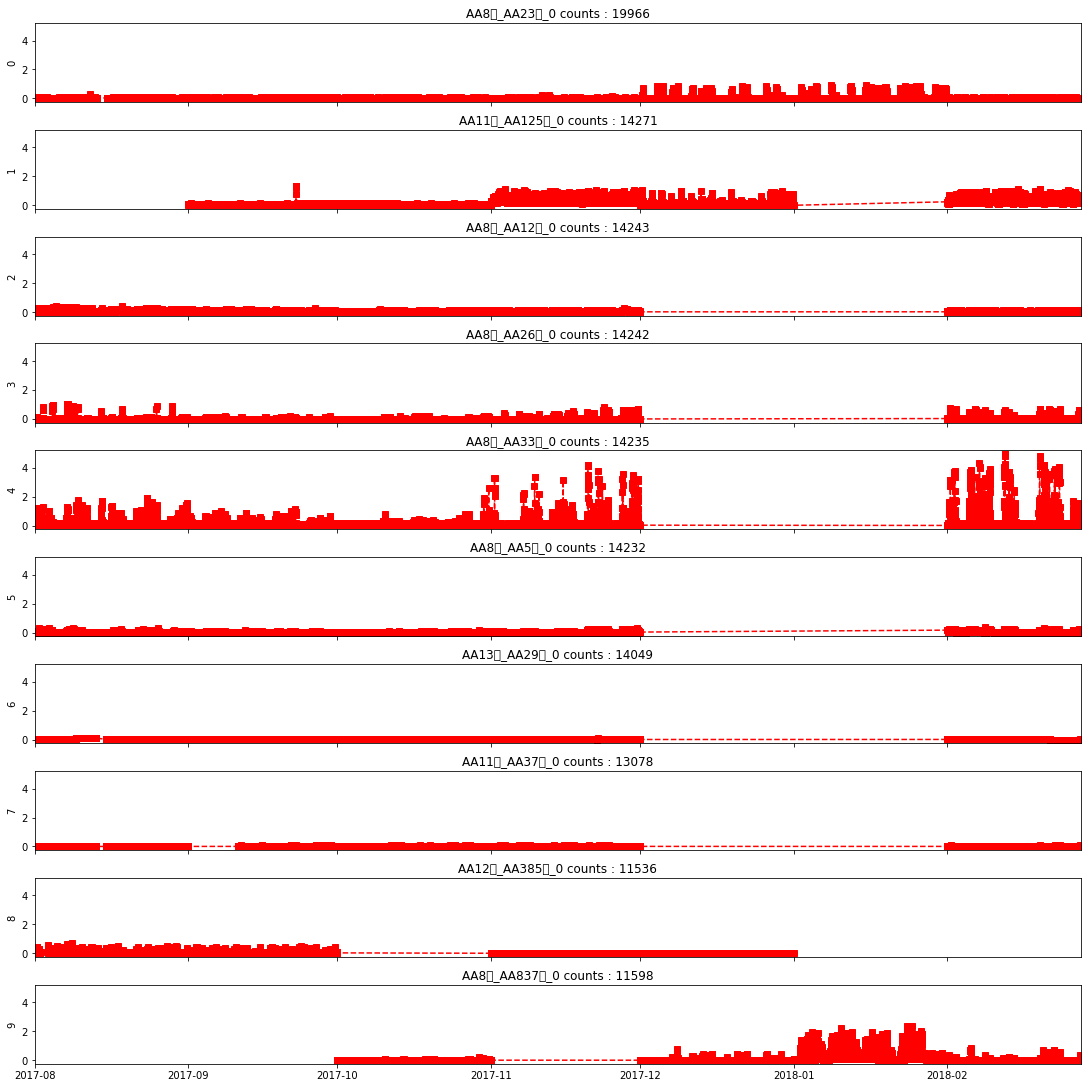

In [659]:
# step 1 : (상위 `10`개)
df_group_A_lists = df_multiple_visualize(df_group_A, 10, 15, 15, start_time = '2017-8-1', end_time = '2018-2-28')

In [611]:
# step 2 : 상위 10개를 csv 파일로 출력하기
df_group_A_lists_end = get_multiple_elements_in_list(df_group_A_lists, np.arange(10))
df_to_csv(df_group_A, weather_data, df_group_A_lists_end, '2017-8-1', '2018-3-1')

### 일반용(갑)저압 시각화 (`contract_type = 1`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)


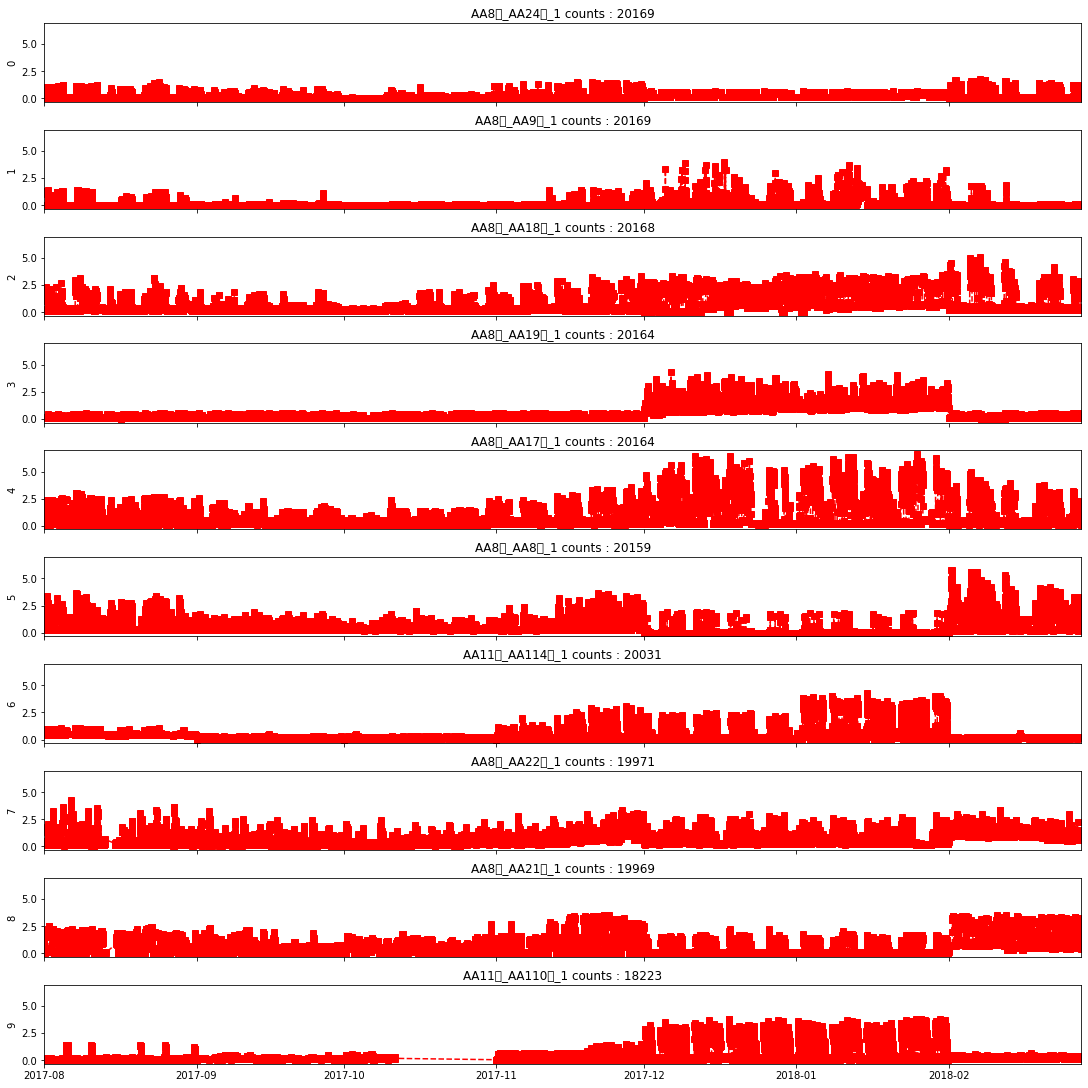

In [662]:
# 일반용(갑)저압 시각화
# step 1 : (상위 `50`개)
df_group_B_lists = df_multiple_visualize(df_group_B, 10, 15, 15, start_time = '2017-8-1', end_time = '2018-2-28')

In [621]:
# step 2 : 상위 10개를 csv 파일로 출력하기
df_group_B_lists_end = get_multiple_elements_in_list(df_group_B_lists, np.arange(10))
df_to_csv(df_group_B, weather_data, df_group_B_lists_end, '2017-8-1', '2018-3-1')

'AA8동_AA24호_1.csv' file has been created.
'AA8동_AA9호_1.csv' file has been created.
'AA8동_AA18호_1.csv' file has been created.
'AA8동_AA19호_1.csv' file has been created.
'AA8동_AA17호_1.csv' file has been created.
'AA8동_AA8호_1.csv' file has been created.
'AA11동_AA114호_1.csv' file has been created.
'AA8동_AA22호_1.csv' file has been created.
'AA8동_AA21호_1.csv' file has been created.
'AA11동_AA110호_1.csv' file has been created.
finished !


### 산업용(갑)저압 시각화 (`contract_type = 2`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)


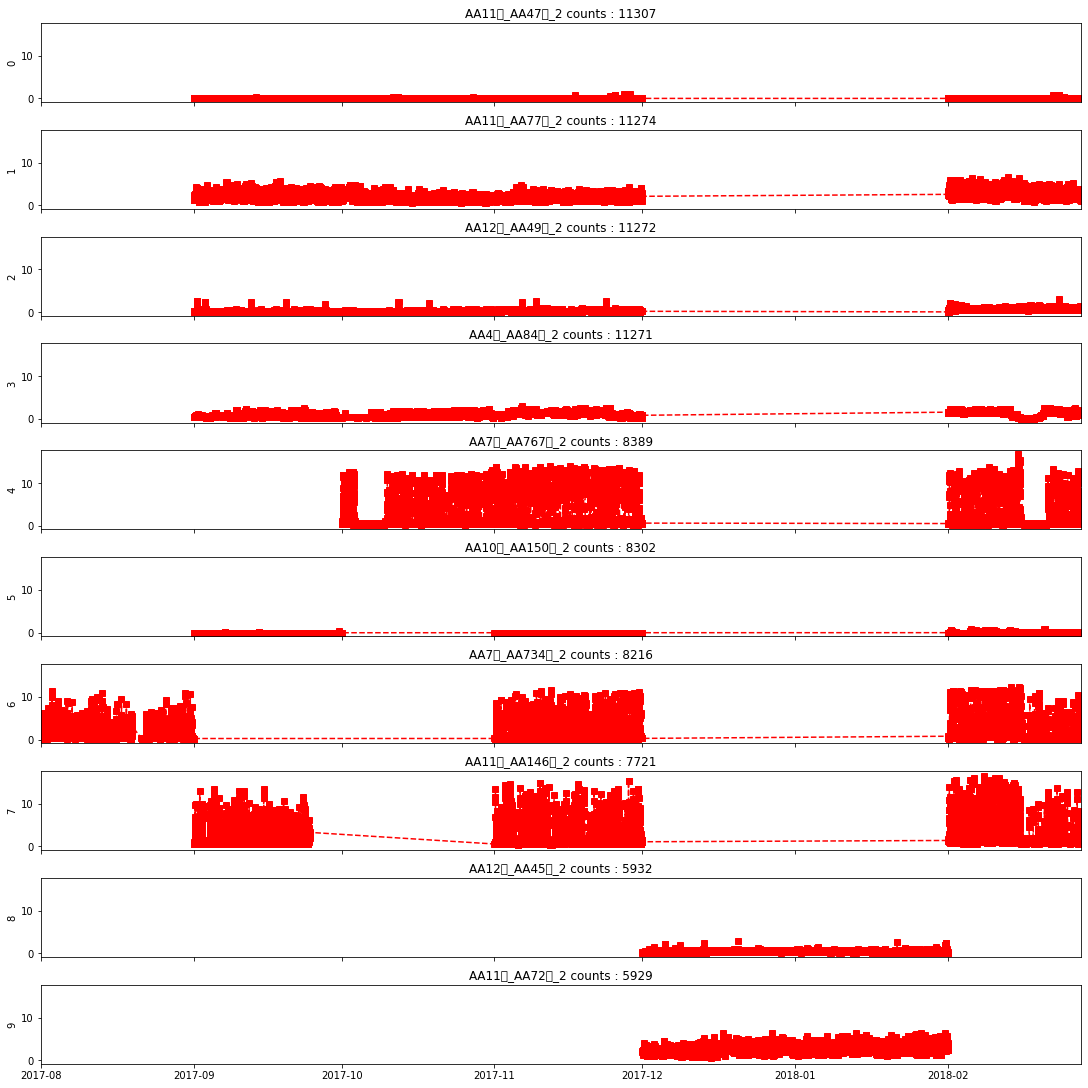

In [663]:
# 산업용(갑)저압 시각화
# step 1 : (상위 `20`개)
df_group_C_lists = df_multiple_visualize(df_group_C, 10, 15, 15, start_time = '2017-8-1', end_time = '2018-2-28')

In [ ]:
# step 2 : 상위 10개를 csv 파일로 출력하기
df_group_C_lists_end = get_multiple_elements_in_list(df_group_C_lists, np.arange(10))
df_to_csv(df_group_C, weather_data, df_group_C_lists_end, '2017-8-1', '2018-3-1')

### 심야전력(갑) 시각화 (`contract_type = 3`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)


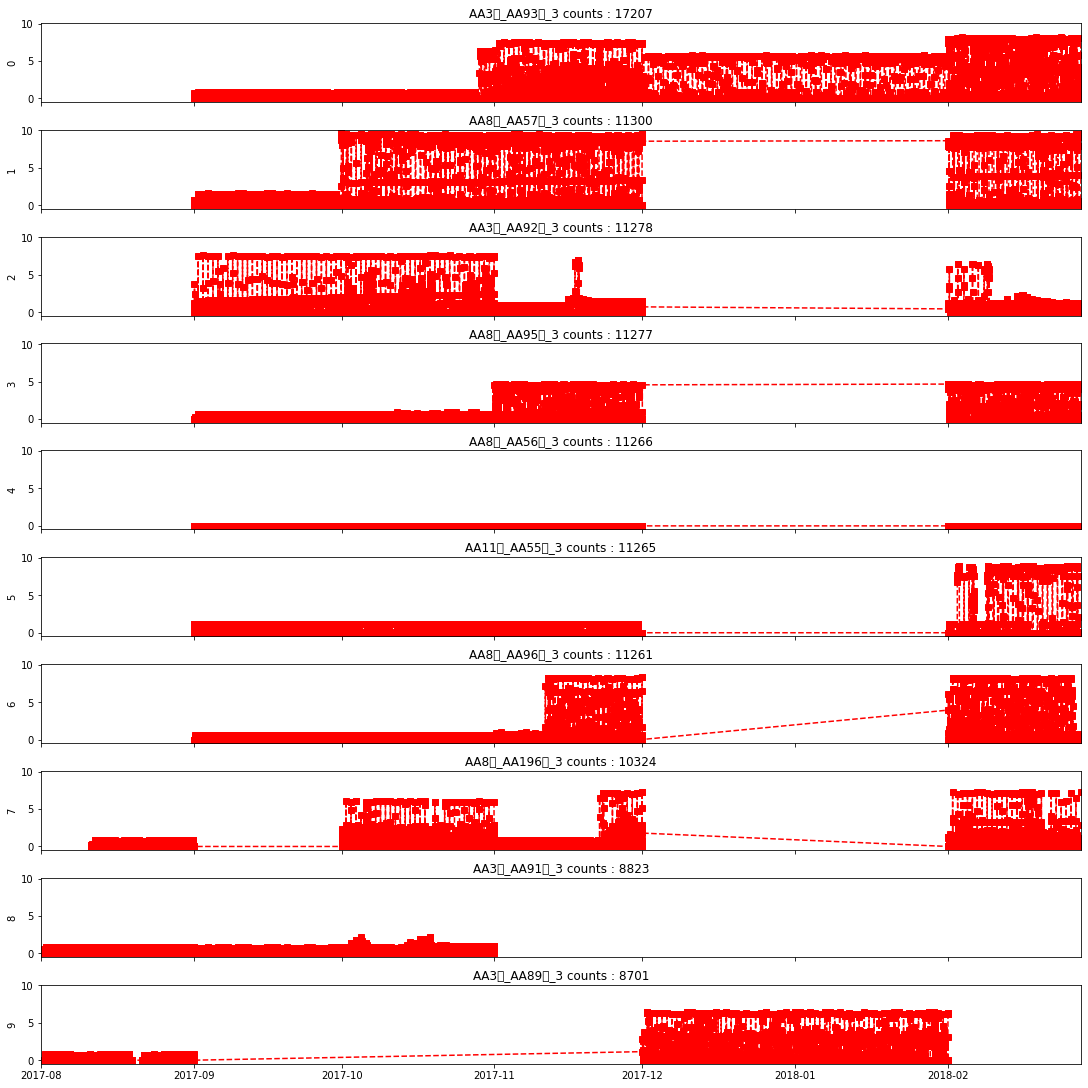

In [664]:
# 심야전력(갑) 시각화
# step 1 : (상위 `20`개)
df_group_D_lists = df_multiple_visualize(df_group_D, 10, 15, 15, start_time = '2017-8-1', end_time = '2018-2-28')

In [ ]:
# step 2 : 상위 10개를 csv 파일로 출력하기
df_group_D_lists_end = get_multiple_elements_in_list(df_group_D_lists, np.arange(10))
df_to_csv(df_group_D, weather_data, df_group_D_lists_end, '2017-8-1', '2018-3-1')

### 농사용(을)저압 시각화 (`contract_type = 4`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)


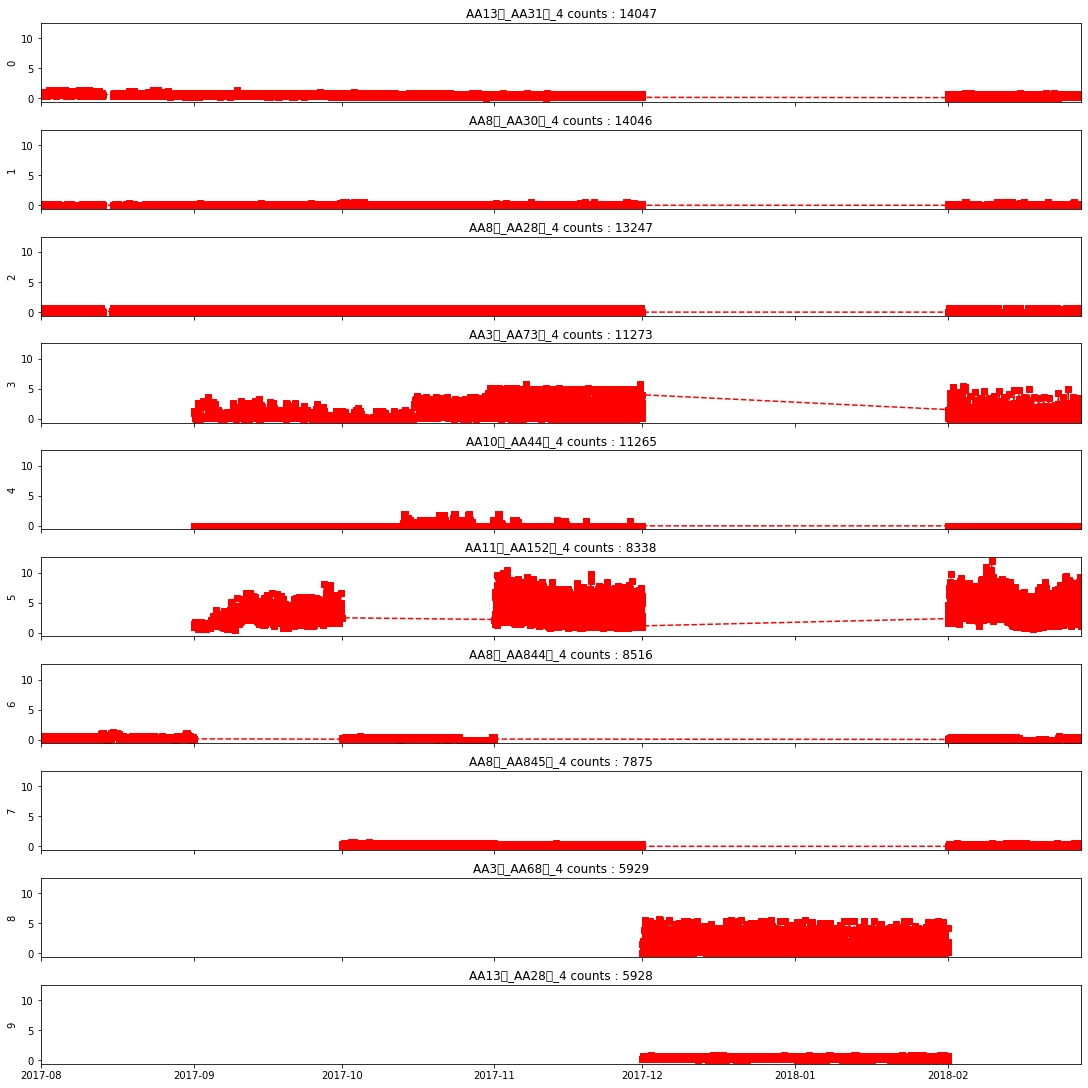

In [665]:
# 농사용(을)저압 시각화
# step 1 : (상위 `20`개)
df_group_E_lists = df_multiple_visualize(df_group_E, 10, 15, 15, start_time = '2017-8-1', end_time = '2018-2-28')

In [ ]:
# step 2 : 상위 10개를 csv 파일로 출력하기
df_group_E_lists_end = get_multiple_elements_in_list(df_group_E_lists, np.arange(10))
df_to_csv(df_group_D, weather_data, df_group_E_lists_end, '2017-8-1', '2018-3-1')

### 농사용(갑) 시각화 (`contract_type = 5`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)


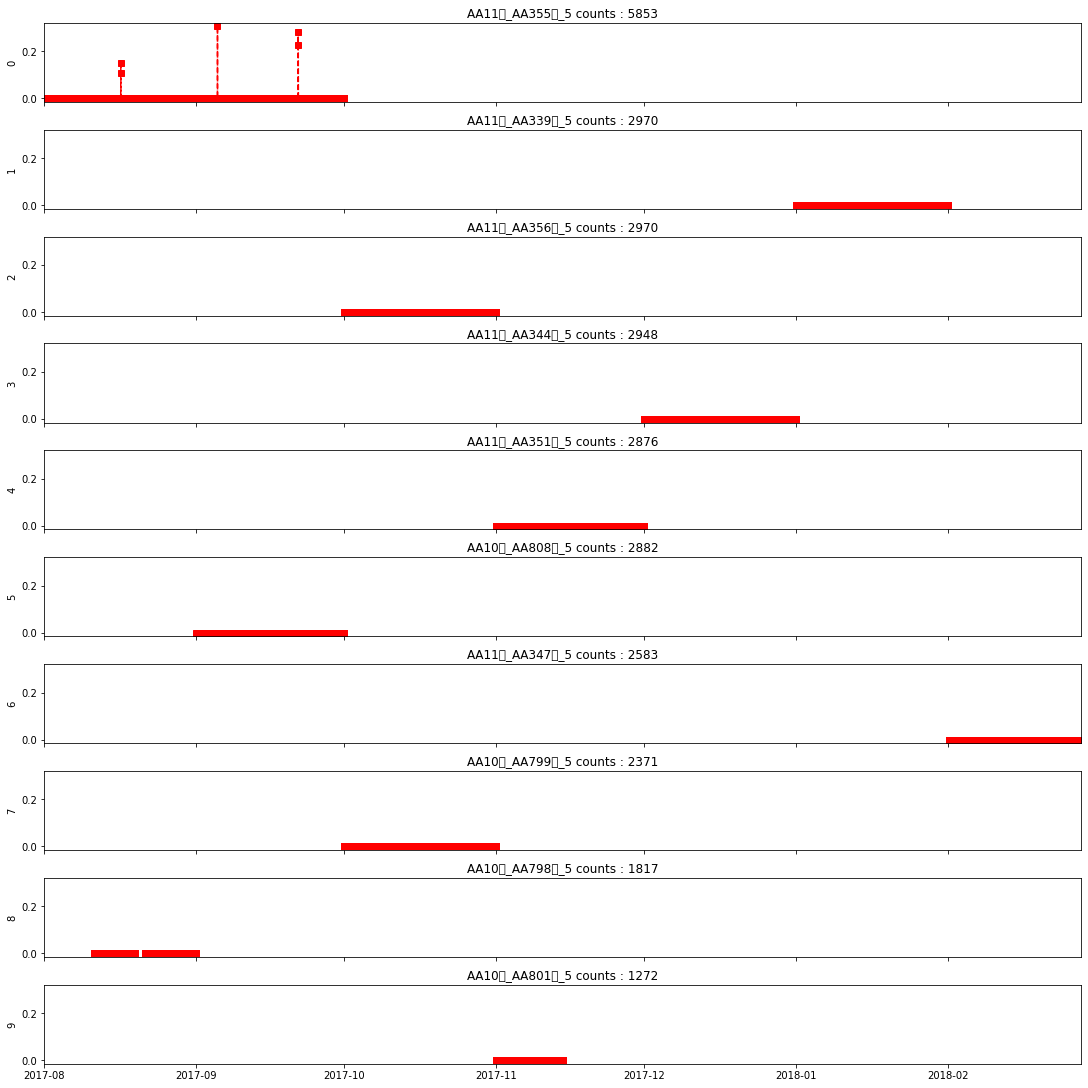

In [666]:
# 농사용(갑) 시각화
# step 1 : (상위 `10`개)
df_group_F_lists = df_multiple_visualize(df_group_F, 10, 15, 15, start_time = '2017-8-1', end_time = '2018-2-28')

In [ ]:
# step 2 : 상위 10개를 csv 파일로 출력하기
df_group_F_lists_end = get_multiple_elements_in_list(df_group_F_lists, np.arange(10))
df_to_csv(df_group_F, weather_data, df_group_F_lists_end, '2017-8-1', '2018-3-1')

### 교육용(갑)저압 (`contract_type = 6`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)


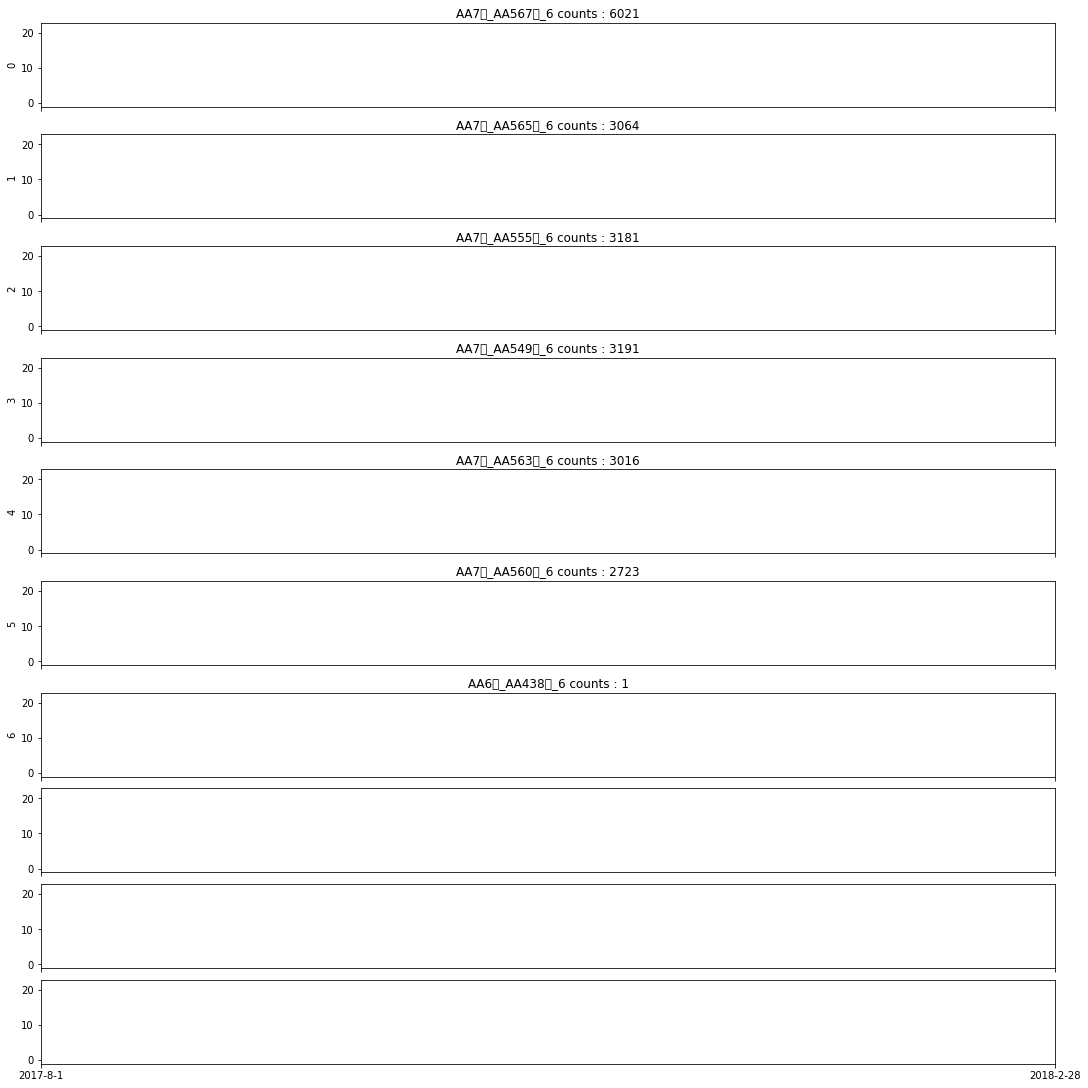

In [667]:
# 교육용(갑)저압 시각화
# step 1 : (상위 `10`개)
df_group_G_lists = df_multiple_visualize(df_group_G, 10, 15, 15, start_time = '2017-8-1', end_time = '2018-2-28')

### 가로등(을) (`contract_type = 7`)

- step 1 : 2017-8-1 ~ 2018-2-28 까지의 유효전력 시각화 (상위 `n`개)
- step 2 : 상위 10개를 csv 파일로 출력하기

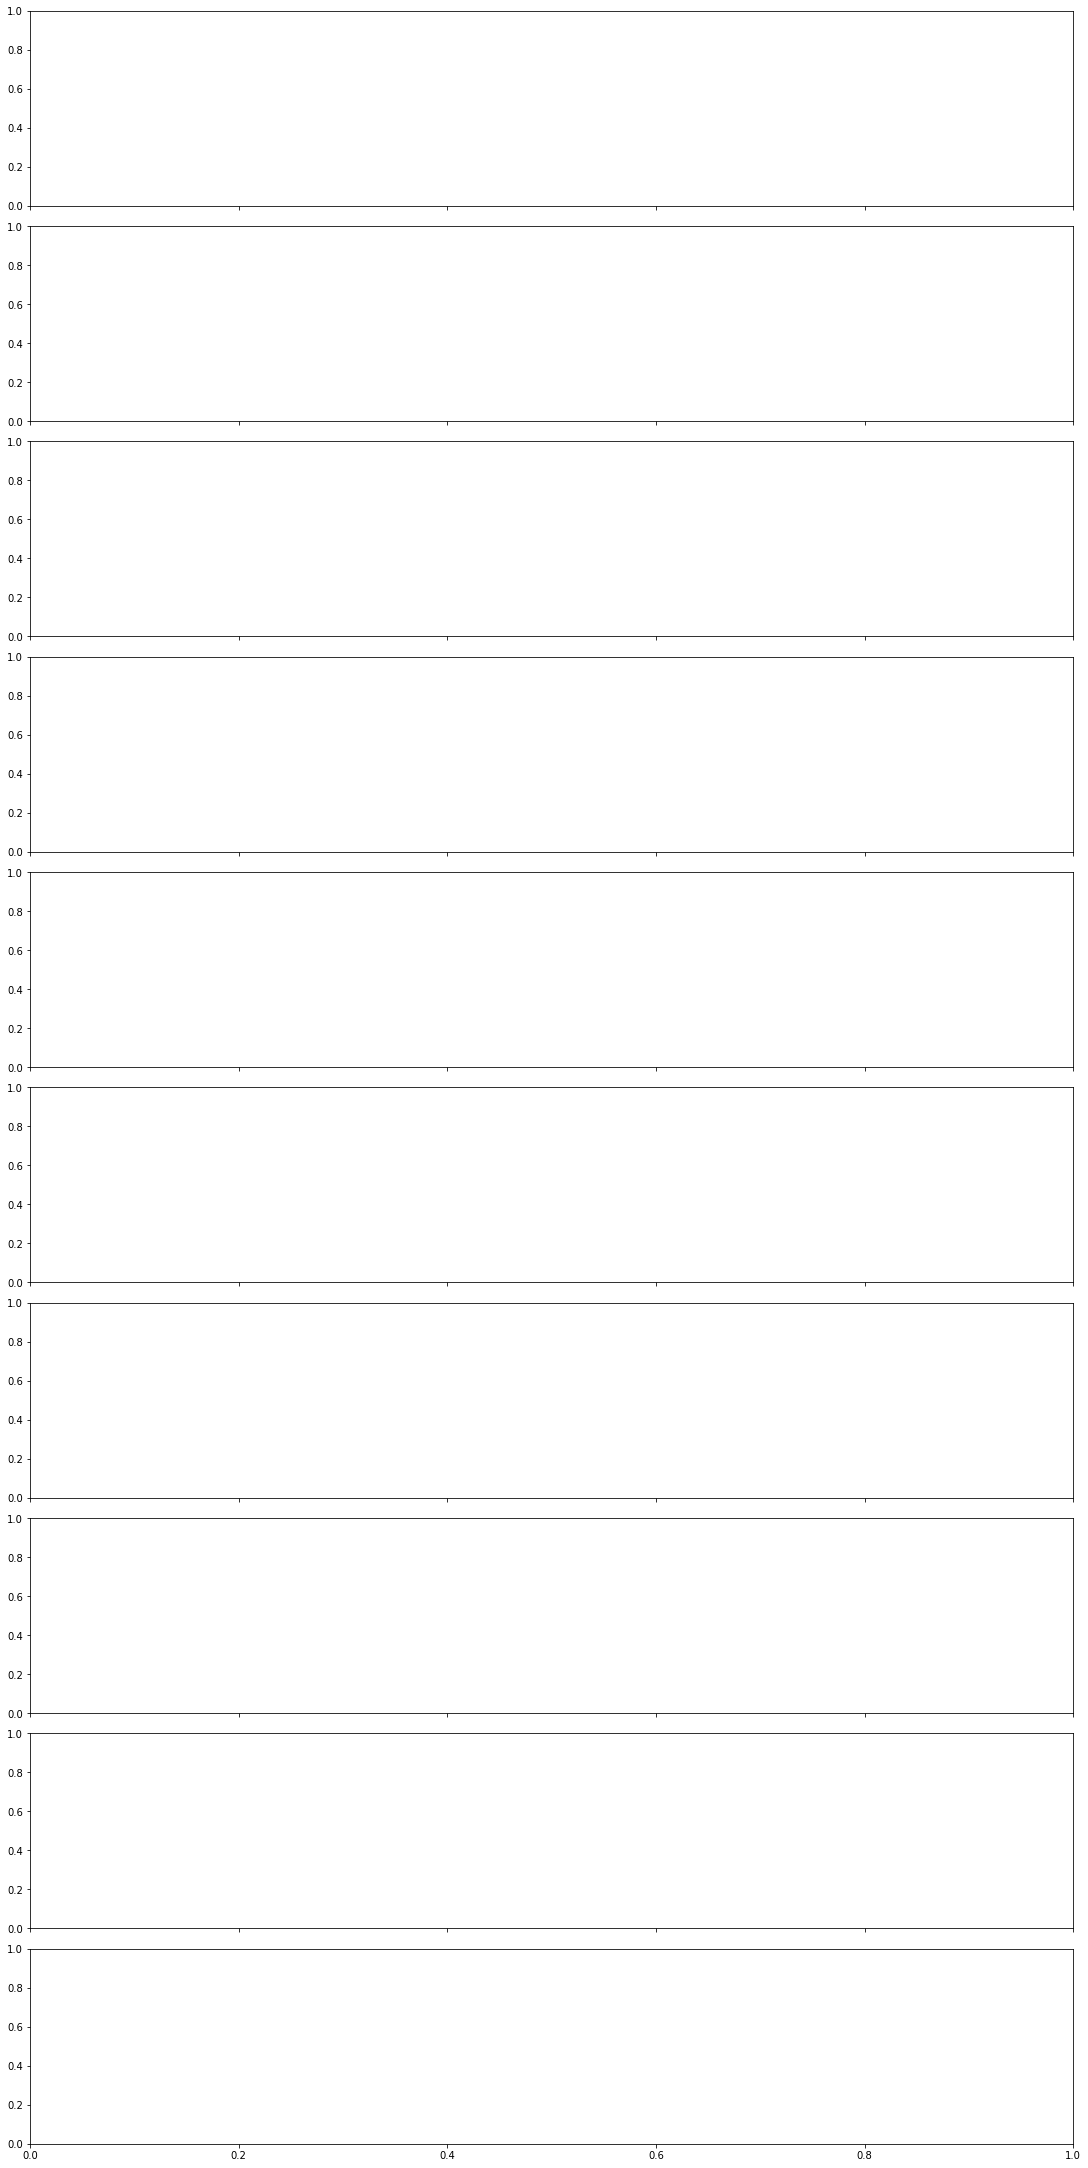

In [632]:
# 교육용(갑)저압 시각화
# step 1 : (상위 `10`개)
df_group_H_lists = df_multiple_visualize(df_group_H, 10, 15, 30, start_time = '2017-8-1', end_time = '2018-2-28')